<a href="https://colab.research.google.com/github/Surafel-Getachew/backpropagation-nn/blob/main/back_propagation_and_creating_NN_lib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def f(x):
  return 3*x**2 - 4*x + 5

In [28]:
f(3.0)

20.0

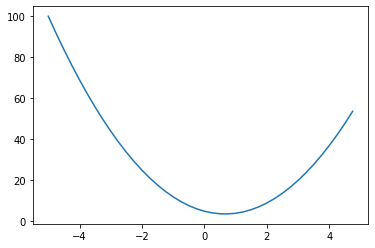

In [29]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [30]:
h = 0.01
x = -3.0
(f(x+h) - f(x))/h


-21.9699999999996

In [31]:
a = 2.0
b = -3.0
c = 10
d = a*b+c
print(d)

4.0


In [32]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b+c
a+=h
d2 = a*b+c

# how the value will react if we tweaked a specific input our case it's a
print("d1",d1)
print("d2",d2)
slope = (d2 - d1)/h
slope


# so this all thing is about derivative
# derivative tells us in a function if we change input value in a function 
# by a bit or higher how is it going to affect the value of f(x) or the result



d1 4.0
d2 3.999699999999999


-3.000000000010772

In [83]:
class Value:
  def __init__(self,data,_children =(), _op="",label = ""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda:None
    self._prev = set(_children)
    self._op = _op
    self.label = label
  
  def __repr__(self):
    return f"Value(data={self.data})"
  
  # what python will do when we do the expression a + b is
  # a.__add__(b)
  def __add__(self,other):
    other  = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data,(self,other),"+")
    def _backward():
      self.grad += 1.0 * out.grad # chain rule
      other.grad += 1.0 * out.grad  # chain rule
    out._backward = _backward
    return out
  
  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)
  
  def __mul__(self,other):
    other  = other if isinstance(other,Value) else Value(other)
    out  = Value(self.data*other.data,(self,other),"*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    tanh = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(tanh,(self,),"tanh")
    def _backward():
      self.grad += (1 - tanh**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),"exp")
    def _backward():
      self.grad += math.exp(x) * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad  = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0,label="a")
b = Value(-3.0,label="b")
c = Value(10,label="c")

# a*b + c
# a.__mul__(b).__add__(c)
e = a*b; e.label = "e"
d = e + c; d.label="d"
f = Value(-2.0,label="f")
L = d * f
L.label = "L"
L 



Value(data=-8.0)

In [84]:
a = Value(3.0)
2 + a

Value(data=5.0)

In [80]:
a = Value(2)
3 + a 

Value(data=5)

In [34]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [35]:
L._op

'*'

In [36]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

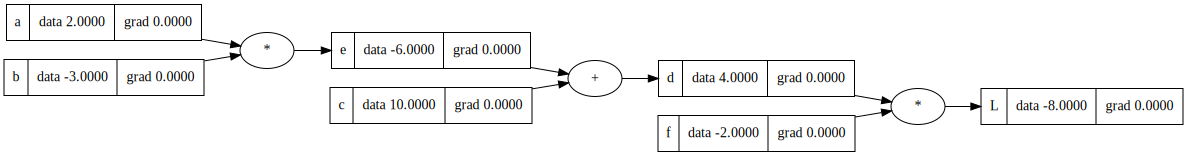

In [37]:
draw_dot(L)


```
L = d * f

# dL/dd = ? f

# Below is the proof that dL/dd is f

f(x+h) - f(x) / h # The defination of derivative

d+h*f - d*f / h  # substuting d * f 

f(d+h) - d*f / h

d*f + h*f - d*f /h

h*f/h

f
```






```
# So what is dL/dc
# First let's compute how c affects d which means dd/dc
d = c + e
dd/dc = 1.0
dd/de = 1.0


# so from chain rule of calculus you can find dL/dc = dd/dc * dL/dd
dL/dc  = 1.0 * f
dL/dc = f


# Here's a manual proof 
dl/dc 
L = b * a + c * f 
L = e + c * f 
f(x + h) - f(x) / h # defination of derivative
e + cf + hf + -e -cf / h
hf/h = f
```





```
Again applying the chain rule let's find how a and b affects L

dL/da = de/da * dL/de

e = a * b 

de/da  = f(x+h) - f(x) / h

de/da  = a + h * b - ab

de/da  = ab + bh - ab = bh/h  = b

dL/da = -3.0 * -2.0

dL/da = 6.0

dL/db = de/db * dL/de = a * dL/de
dL/db = 2.0 * -2.0 = -4.0



```



In [38]:
L.grad = 1.0 # because if you add a little value like 0.001 and compute the derivative it's actually 1 

# From the above proof
# dL/dd = f also
# dL/df = d 

d.grad = f.data
f.grad = d.data

c.grad = f.data
e.grad = f.data

a.grad = 6.0
b.grad = -4.0




In [39]:
def lol():

  h = 0.001

  a = Value(2.0,label="a")
  b = Value(-3.0,label="b")
  c = Value(10,label="c")
  e = a*b; e.label = "e"
  d = e + c; d.label="d"
  f = Value(-2.0,label="f")
  L = d * f; L.label = "L"
  L1 = L.data
  
  # a = Value(2.0,label="a")
  # for finding the derivative with respect to a
  a = Value(2.0 + h,label="a")
  b = Value(-3.0,label="b")
  c = Value(10,label="c")
  e = a*b; e.label = "e"
  d = e + c; d.label="d"
  f = Value(-2.0,label="f")
  L = d * f; L.label = "L"
  L2 = L.data

  print((L2-L1)/h)
lol()

6.000000000000227


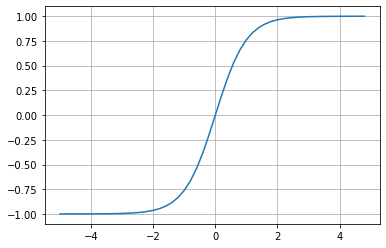

In [40]:
plt.plot(np.arange(-5.0,5.0,0.2),np.tanh(np.arange(-5.0,5.0,0.2))); plt.grid()

In [41]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


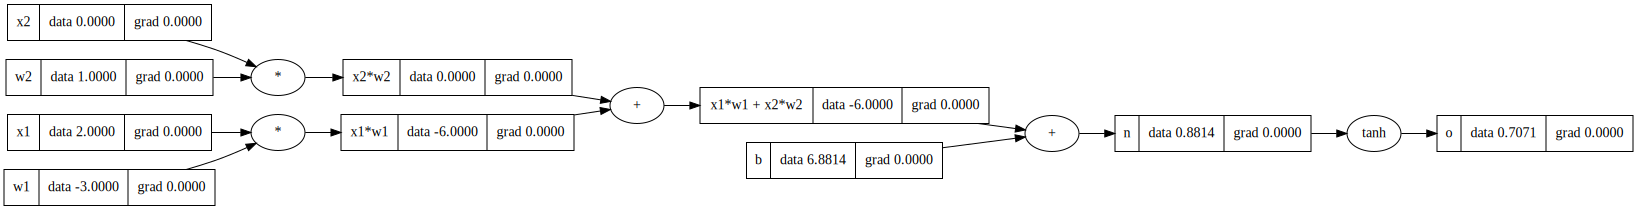

In [42]:
draw_dot(o) 

<class '__main__.Value'>


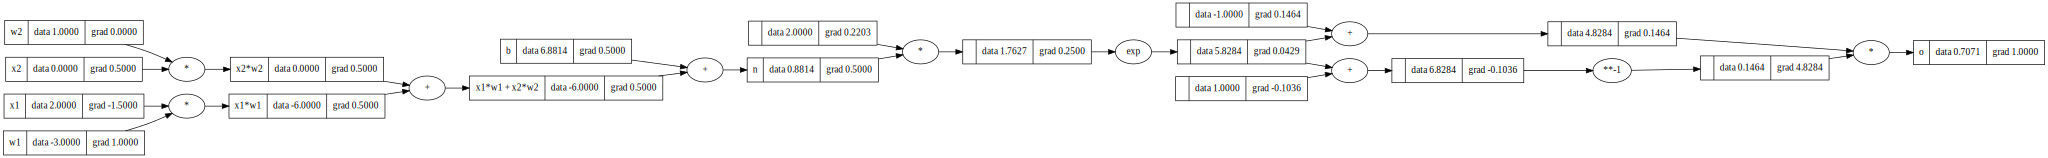

In [43]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----------------------
e = (2*n).exp()
o = (e-1) / (e+1)
o.label = "o"
print(type(o))
o.backward()
draw_dot(o)

In [44]:
# Manually we can calculate the grad like below
o.grad = 1.0
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 # This forumula can be found in wikipida of tanh 
# do/dn = 1 - o**2
n.grad = 1 - o.data**2
# now for b.grad which is dodb
# because it's + operation it just simply flow carrying the derivative of do/dn
# same thing happens for x1*w1 + x2*w2
b.grad = n.grad
x1w1x2w2.grad = n.grad
# again 0.5 flows because it's a + operator
x1w1.grad = 0.5
x2w2.grad = 0.5

# and the derivative of do/dx2 = dx2w2/dx2 * do/dx2w2
# now derivative of dx2w2/dx2 = w2; therefore 
x2.grad = w2.data * x2w2.grad
# same chain rule applies for w2,w1 and x1
w2.grad = x2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad



In [45]:
# now we can calculate the backward propagation automatically by using the _backward func for each input
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()




In [46]:
o.backward() # even better we can calculate the grad of every input starting from the right most.

Pytorch implementation

In [47]:
import torch

In [48]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Neuron

In [133]:
import random

class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self,x):
   # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layers:
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self,x):
    out = [n(x) for n in self.neurons]
    return out[0] if len(out) == 1 else out
  
  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP:
  def __init__(self,nin,nouts): # here nouts means number of layers excluding the output
    sz = [nin] + nouts
    self.layers = [Layers(sz[i],sz[i+1]) for i in range(len(nouts))]
 
  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    # params = []
    # for layer in self.layers:
    #   ps = layer.parameters()
    #   params.extend(ps)
    # return params
    return [p for layer in self.layers for p in layer.parameters()]



In [196]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets



In [197]:
n = MLP(3,[4,4,1])

In [234]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]

  # mean squared error loss
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update w and b
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k,loss.data)



0 0.00015433515213747736
1 0.00015424665960466985
2 0.00015415826542520398
3 0.00015406996943711108
4 0.00015398177147877553
5 0.0001538936713889253
6 0.00015380566900665533
7 0.00015371776417140055
8 0.0001536299567229397
9 0.00015354224650141688
10 0.0001534546333473099
11 0.0001533671171014473
12 0.0001532796976050034
13 0.00015319237469950145
14 0.00015310514822680047
15 0.0001530180180291093
16 0.00015293098394897445
17 0.00015284404582928575
18 0.00015275720351327402
19 0.000152670456844504


In [236]:
ypred

[Value(data=0.9945769595341359),
 Value(data=-0.9934390466431473),
 Value(data=-0.9949140632977523),
 Value(data=0.9926278749427293)]

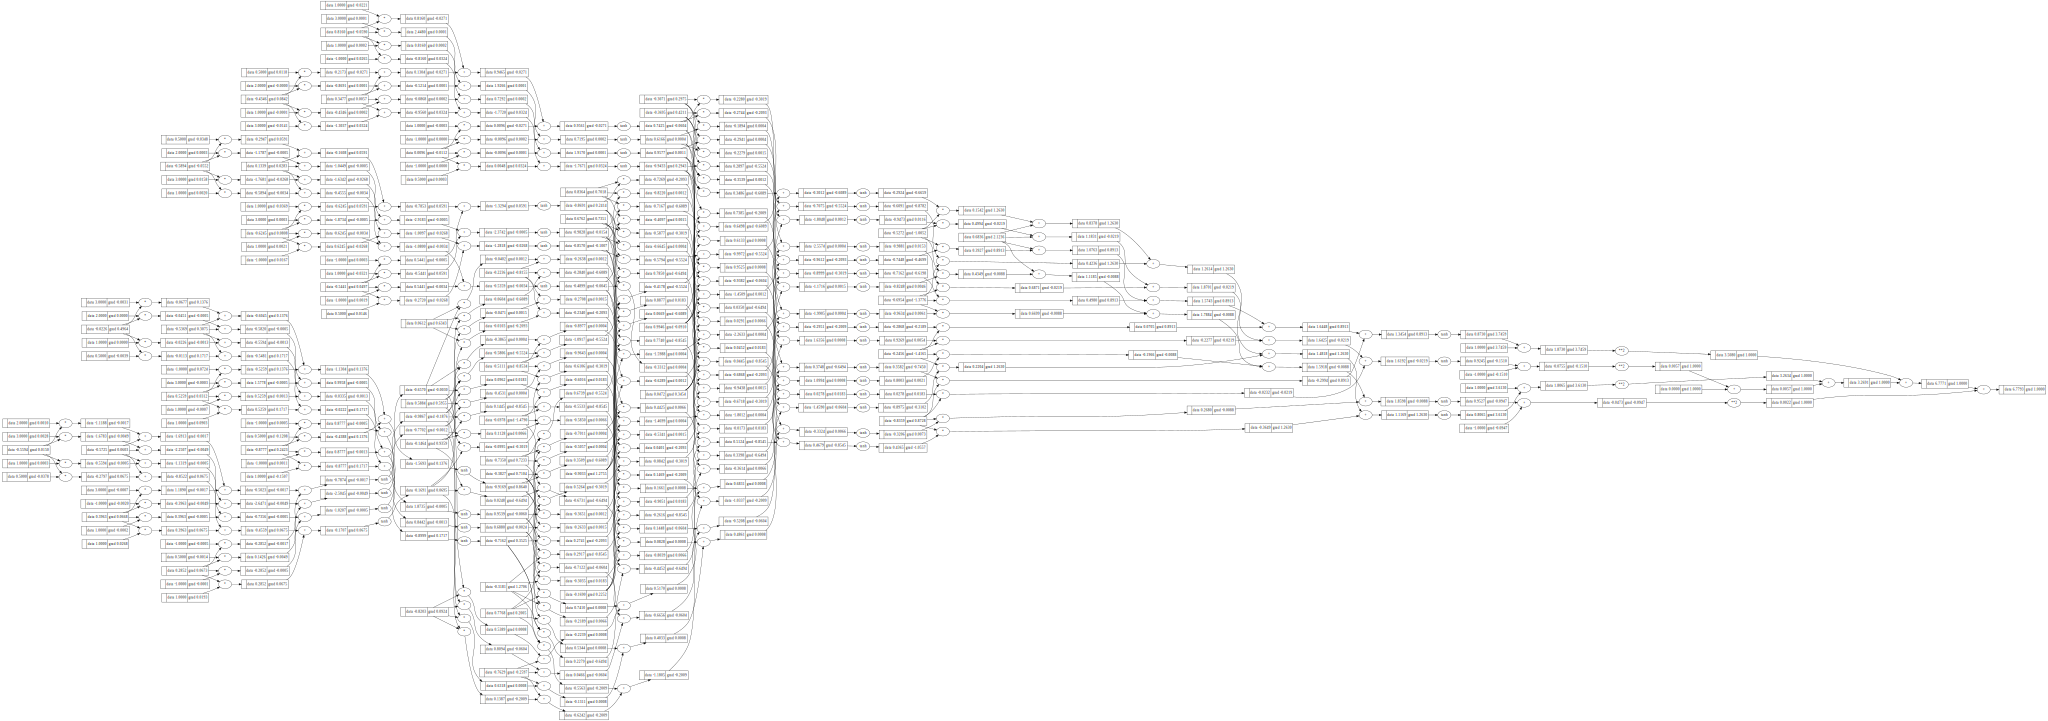

In [93]:
draw_dot(loss)